In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from collections import defaultdict

from Components.ConditionalNormalDistribution import ConditionalNormalDistribution
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelExponential import ModelExponential
from Models.ModelSinCos import ModelSinCos
from Models.ModelLogistic import ModelLogistic
from Models.ModelSigmoid import ModelSigmoid
from Composition.SequentialSystem import SequentialSystem
from SearchAlgorithm.skeleton import BO_skeleton, BO_graph, BO_graph_turbo, BO_graph_local_loss, BO_graph_local_loss_with_explicit_noise

from GraphDecomposition.DirectedFunctionalGraph import DirectedFunctionalGraph
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelSinCos import ModelSinCos
from Models.ModelConstant import ModelConstant
from Models.ModelWeightedSum import ModelWeightedSum
from Models.ModelExponential import ModelExponential

%load_ext autoreload
%autoreload 2
from GraphDecomposition.Heuristic import *
from helper import *
from Plotting.HeatMapLossFunction import *

torch.manual_seed(10)

In [2]:
# ground truth param

ground_truth_param = {1 : np.array([0.7, 0.9, -0.5]), 2: np.array([0.3, 0.7]), 8: np.array([-0.2, -0.2]), 9: np.array([-0.5, 0.5]), 10: np.array([-0.2, 0.1]), 11: np.array([-0.3, 0.3, 0.2]),
                      12: np.array([0.1, 0.1]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([1.1, -0.5]), "Blackbox5":np.array([0.7, -0.5]),
                      "Blackbox6": np.array([0.7, 1.1]), 7: np.array([0.7, -0.5])}



# Generate the system

adding edge from Blackbox6 to Blackbox3
adding edge from 7 to Blackbox3
adding edge from 1 to Blackbox3
adding edge from 2 to Blackbox3
adding edge from 4 to Blackbox5
adding edge from 2 to Blackbox5
adding edge from 7 to Blackbox6
adding edge from Blackbox5 to Blackbox6
setting:  [ 0.7  0.9 -0.5]
setting:  [0.3 0.7]
setting:  [ 1.1 -0.5]
setting:  [ 0.7 -0.5]
setting:  [-0.2 -0.2]
setting:  [-0.5  0.5]
setting:  [-0.2  0.1]
setting:  [-0.3  0.3  0.2]
setting:  [0.1 0.1]
setting:  [1.2 0.8]
setting:  [ 0.7 -0.5]
setting:  [0.7 1.1]


/home/chenzhil/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:36: UserWarning: Parents of Blackbox3 previously defined as ['Blackbox6', 7], attempting to overwrite with [1, 2]
  warnings.warn(f'Parents of {v_of_edge} previously defined as {self.nodes[v_of_edge]["parents"]}, attempting to overwrite with {u_of_edge}')
/home/chenzhil/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:36: UserWarning: Parents of 4 previously defined as [2], attempting to overwrite with ['Blackbox3']
  warnings.warn(f'Parents of {v_of_edge} previously defined as {self.nodes[v_of_edge]["parents"]}, attempting to overwrite with {u_of_edge}')


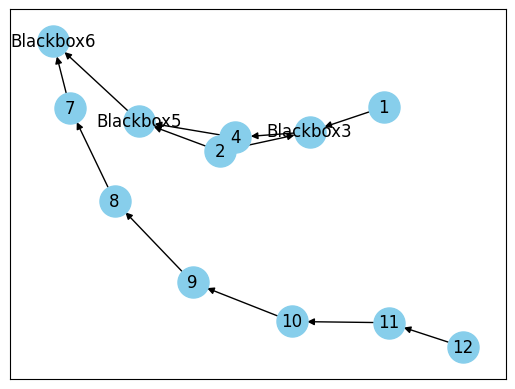

In [3]:
DG = generate_dg(ground_truth_param,noise=0.05,seed=5)
nx.draw_networkx(DG, node_size=500, node_color="skyblue")
plt.show()

# Gradient Descent of local components

final system loss:  tensor(0.1729, dtype=torch.float64)


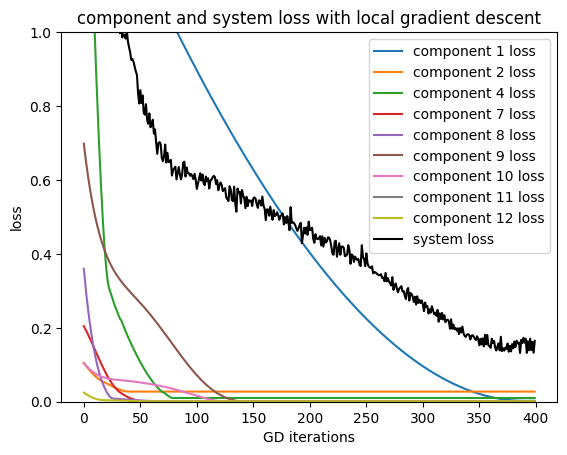

best system loss: tensor(0.1318, dtype=torch.float64)


In [4]:
torch.manual_seed(10)
#grad descent
DG.random_initialize_param(100)
lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(DG, itr=400, plot=True)
lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# DG.random_initialize_param(100)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(DG, itr=400, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# DG.random_initialize_param(100)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(DG, itr=400, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# DG.random_initialize_param(100)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(DG, itr=400, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

# torch.manual_seed(10)
# #grad descent
# DG.random_initialize_param(100)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(DG, itr=400, plot=True)
# lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
# print("best system loss:", min(all_loss["system"]))

In [4]:
DG.system_y

tensor([1.8578, 1.6438, 1.5730, 1.5065, 1.7841, 1.6959, 1.6927, 1.6770, 1.5412,
        1.7148, 1.7812, 1.5272, 1.5973, 1.6448, 1.6800, 1.7490, 1.9324, 1.6506,
        1.9096, 1.5936, 1.8095, 1.9446, 1.5608, 1.7636, 1.6871, 1.7213, 1.7211,
        1.6379, 1.6547, 1.8710, 1.7003, 1.5041, 1.7153, 1.8237, 1.9619, 1.7495,
        1.7890, 1.7129, 1.6612, 1.6856, 1.5150, 1.9027, 1.7557, 1.9093, 1.6690,
        1.7719, 1.6489, 1.9661, 1.5412, 1.7740, 1.6893, 1.7424, 1.7777, 1.9659,
        1.5370, 1.7190, 1.6615, 1.6045, 1.9269, 1.8928, 1.8417, 1.6451, 1.8029,
        1.7429, 1.6946, 1.7716, 1.4966, 1.8771, 1.6207, 1.8291, 1.5715, 1.5750,
        1.7134, 1.8571, 1.8384, 1.5903, 1.3068, 1.9117, 1.7571, 1.6315, 1.6276,
        1.5561, 1.6310, 1.5874, 1.6220, 1.7356, 1.5625, 1.5767, 1.9191, 1.6017,
        1.8523, 1.7344, 1.8235, 2.0436, 1.6395, 1.8993, 1.7126, 1.8290, 1.5632,
        1.7046], dtype=torch.float64)

In [ ]:

DG.random_initialize_param(5)
print(DG.get_system_loss())


tensor(1.5735, dtype=torch.float64)


In [ ]:
from numpy import genfromtxt
import pandas as pd
import scipy
def plot_trials_regret(csv_file, legend="",c="b", iteration=200, end_iteration=0):
    my_data = genfromtxt(csv_file, delimiter=' ')
    
    starting_iteration = 0
    
    # interpolate
    my_data_new = []
    
    if not my_data.ndim == 1:
        if len(my_data[0]) < iteration:
            for trial in my_data:
                #trial = np.insert(trial, 0,3.5)
                trial_new = np.full(iteration, np.nan)
                trial_new[::int((iteration/len(trial)))] = trial
                trial_new = pd.Series(trial_new).interpolate().tolist()
                my_data_new.append(trial_new)
            my_data = np.array(my_data_new)
    
    #my_data = np.hstack((np.ones((my_data.shape[0], 1)) * -2.8, my_data))
    mean = -1 * np.mean(np.array(my_data), axis=0)[:end_iteration]
    std = scipy.stats.sem(np.array(my_data), axis=0)[:end_iteration]
    
    # mean = np.insert(mean, 0, 2.5)
    # std = np.insert(std, 0, 0.2)
    print("mean shape: ", mean[-1])
    print("std shape: ", std[-1])
    # pad
    # if len(mean) < iteration:
    #     mean = np.array([x for x in mean for _ in range(int(iteration / len(mean)))])
    #     std = np.array([x for x in std for _ in range(int(iteration / len(std)))])

    plt
    plt.plot(range(len(mean[starting_iteration:])), mean[starting_iteration:],c=c,linewidth=1.5,solid_capstyle='round',label=legend)
    plt.fill_between(range(len(mean[starting_iteration:])), mean[starting_iteration:]-std[starting_iteration:], mean[starting_iteration:]+std[starting_iteration:], color=c, alpha=0.1)
    plt.legend(fontsize=15)
    plt.xlabel("system queries", fontsize=15)
    plt.ylabel("system loss", fontsize=15)
    plt.xticks(np.arange(0.0,end_iteration+1,25))
    plt.ylim(0, 5)
    #plt.yticks(np.arange(0.0,20,5))
    # plt.title(csv_file)
    # plt.show()

mean shape:  0.02854644537920989
std shape:  0.004126931217707039
mean shape:  0.0639101800069543
std shape:  0.02005005814788793


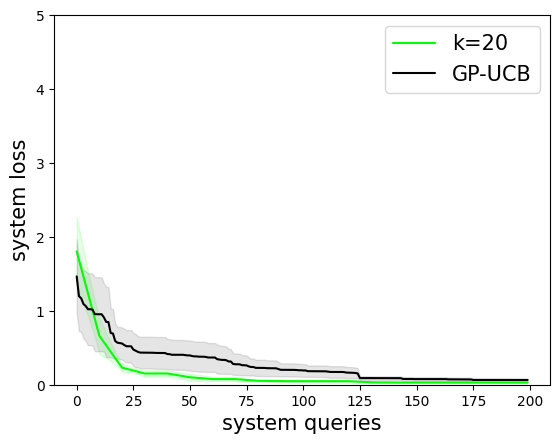

In [ ]:
plot_trials_regret("result/our_bo_20_runB_10.csv", legend="k=20",c="lime", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/vanilla_BO_200_runB.csv", legend="GP-UCB",c="black", iteration=iterations, end_iteration=end_iteration)


mean shape:  0.15295877533646002
std shape:  0.0078044462173825204
mean shape:  0.13971903654420692
std shape:  0.006024662208446789
mean shape:  0.15751266424661559
std shape:  0.002829642594439884
mean shape:  0.14811151396825598
std shape:  0.00199741953513751
mean shape:  0.12834017971057915
std shape:  0.00219902494877081
mean shape:  0.19920984046270201
std shape:  0.008631703733794743


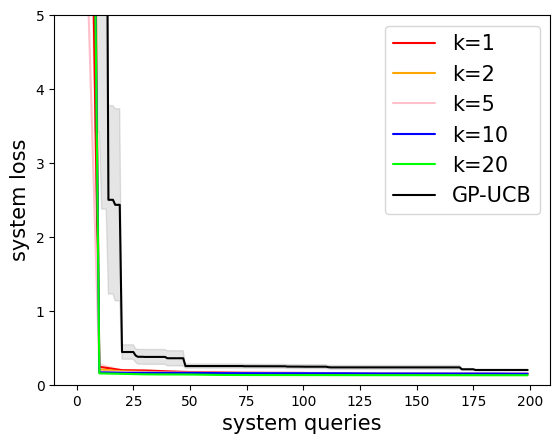

In [ ]:
iterations = 200
end_iteration = 200
plot_trials_regret("result/mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_1.csv", legend="k=1",c="red", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_2.csv", legend="k=2",c="orange", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_5.csv", legend="k=5",c="pink", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_10.csv", legend="k=10",c="blue", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_20.csv", legend="k=20",c="lime", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/mnist_vanilla_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2.csv", legend="GP-UCB",c="black", iteration=iterations, end_iteration=end_iteration)


mean shape:  4.974933491043311
std shape:  0.3655789617750432


mean shape:  5.0563094143144935
std shape:  0.3020838813409036
mean shape:  6.372511189101978
std shape:  0.7085991204063926
mean shape:  4.487542336071389
std shape:  0.7312467859485388
mean shape:  3.980648934668223
std shape:  0.3250314084812759
mean shape:  6.46152881327031
std shape:  0.1720908326094094


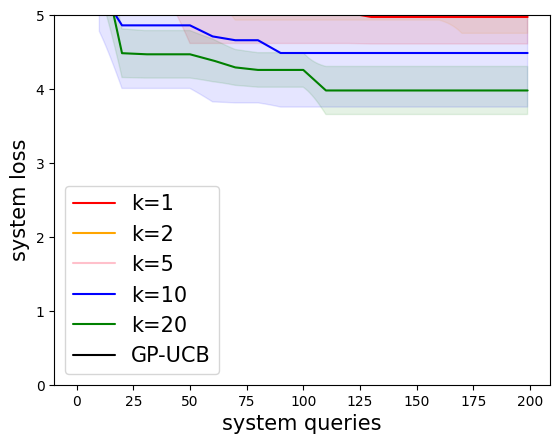

In [ ]:
iterations = 200
end_iteration = 200
plot_trials_regret("result/health_care_3_neg_1_0.5_start_seed_11_1.csv", legend="k=1",c="red", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/health_care_3_neg_1_0.5_start_seed_11_2.csv", legend="k=2",c="orange", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/health_care_3_neg_1_0.5_start_seed_11_5.csv", legend="k=5",c="pink", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/health_care_3_neg_1_0.5_start_seed_11_10.csv", legend="k=10",c="blue", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/health_care_3_neg_1_0.5_start_seed_11_20.csv", legend="k=20",c="green", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/health_care_vanilla_BO.csv", legend="GP-UCB",c="black", iteration=iterations, end_iteration=end_iteration)


mean shape:  0.5470535885958423
std shape:  0.21595900450992886
mean shape: 

 0.4415532892449434
std shape:  0.09786042226850081
mean shape:  0.2840495914235768
std shape:  0.04795972774890086
mean shape:  0.283155928679641
std shape:  0.03977456324607605
mean shape:  0.19981393051644125
std shape:  0.05096960170451301


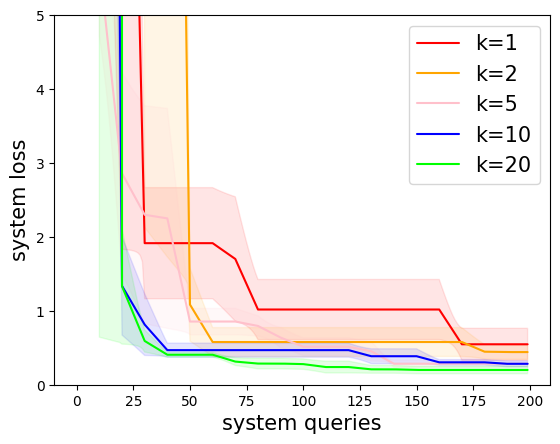

In [ ]:
iterations = 200
end_iteration = 200
plot_trials_regret("result/large_mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_1.csv", legend="k=1",c="red", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/large_mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_2.csv", legend="k=2",c="orange", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/large_mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_5.csv", legend="k=5",c="pink", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/large_mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_10.csv", legend="k=10",c="blue", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/large_mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_20.csv", legend="k=20",c="lime", iteration=iterations, end_iteration=end_iteration)
#plot_trials_regret("result/large_mnist_vanilla_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2.csv", legend="GP-UCB",c="black", iteration=iterations, end_iteration=end_iteration)


mean shape:  0.14811151396825598
std shape:  0.00199741953513751
mean shape:  0.19920984046270201
std shape:  0.008631703733794743


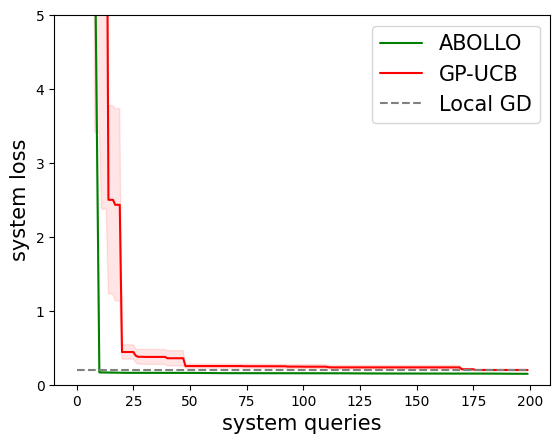

In [ ]:
iterations=200
end_iteration=200

plot_trials_regret("result/mnist_our_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2_10.csv", legend="ABOLLO",c="green", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/mnist_vanilla_BO_data_seed_99_starting_grad_seed_5_noise_pos_0.3_std_0.2.csv", legend="GP-UCB",c="red", iteration=iterations, end_iteration=end_iteration)
plt.plot(range(0,end_iteration), [0.205]*end_iteration, c="grey", linestyle='--', label="Local GD")
plt.legend(fontsize=15)
#plt.title("System A")

mean shape:  4.487542336071389
std shape:  0.7312467859485388
mean shape:  6.46152881327031
std shape:  0.1720908326094094


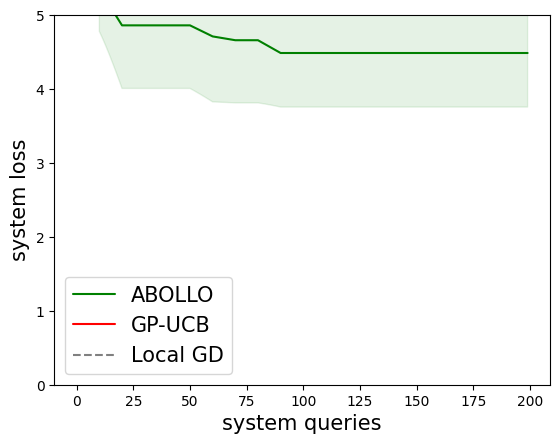

In [ ]:
iterations=200
end_iteration=200

plot_trials_regret("result/health_care_3_neg_1_0.5_start_seed_11_10.csv", legend="ABOLLO",c="green", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/health_care_vanilla_BO.csv", legend="GP-UCB",c="red", iteration=iterations, end_iteration=end_iteration)
plt.plot(range(0,end_iteration), [5.024]*end_iteration, c="grey", linestyle='--', label="Local GD")
plt.legend(fontsize=15)
#plt.title("System A")

mean shape:  0.06370183440524671
std shape:  0.011437472393658216
mean shape:  0.11784845834506028
std shape:  0.044238717124270056
mean shape:  0.05037997122598028
std shape:  0.009839580464590368
mean shape:  0.02854644537920989
std shape:  0.004126931217707039
mean shape:  0.06626481247180183
std shape:  0.031117026023717402


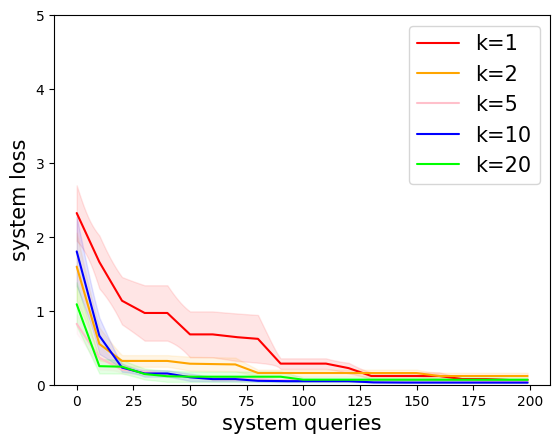

In [ ]:

iterations=200
end_iteration=200
plot_trials_regret("result/our_bo_20_runB_1.csv", legend="k=1",c="red", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/our_bo_20_runB_2.csv", legend="k=2",c="orange", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/our_bo_20_runB_5.csv", legend="k=5",c="pink", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/our_bo_20_runB_10.csv", legend="k=10",c="blue", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/our_bo_20_runB_20.csv", legend="k=20",c="lime", iteration=iterations, end_iteration=end_iteration)
#plot_trials_regret("result/our_bo_20_runB_30.csv", legend="k=30",c="green", iteration=iterations, end_iteration=end_iteration)

#plot_trials_regret("result/vanilla_BO_200_runB.csv", legend="GP-UCB",c="black", iteration=iterations, end_iteration=end_iteration)




In [ ]:

iterations=200
end_iteration=200
# plot_trials_regret("result/BO_k_samples/BO_ours_10_itr_1_samples_new.csv", legend="k=1",c="red", iteration=iterations, end_iteration=end_iteration)
# plot_trials_regret("result/BO_k_samples/BO_ours_10_itr_3_samples_new.csv", legend="k=3",c="orange", iteration=iterations, end_iteration=end_iteration)
# plot_trials_regret("result/BO_k_samples/BO_ours_10_itr_5_samples_new.csv", legend="k=5",c="blue", iteration=iterations, end_iteration=end_iteration)
# plot_trials_regret("result/BO_k_samples/BO_ours_10_itr_10_samples_new.csv", legend="k=10",c="green", iteration=iterations, end_iteration=end_iteration)
# plot_trials_regret("result/BO_k_samples/BO_vanilla_100_itr_compare_k_samples.csv", legend="k=1",c="black", iteration=iterations, end_iteration=end_iteration)

plot_trials_regret("result/BO_k_samples_runA/our_bo_20_runA_2.csv", legend="k=1",c="red", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/BO_k_samples_runA/our_bo_20_runA_5.csv", legend="k=3",c="orange", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/BO_k_samples_runA/our_bo_20_runA_10.csv", legend="k=5",c="blue", iteration=iterations, end_iteration=end_iteration)
plot_trials_regret("result/BO_k_samples_runA/our_bo_20_runA_20.csv", legend="k=10",c="green", iteration=iterations, end_iteration=end_iteration)
#plot_trials_regret("result/BO_k_samples_runA/vanilla_BO_200_runA.csv", legend="k=1",c="black", iteration=iterations, end_iteration=end_iteration)



FileNotFoundError: result/BO_k_samples_runA/our_bo_20_runA_2.csv not found.

In [ ]:
mean = np.mean(np.array(vanilla_all_trials), axis=0)
std = np.std(np.array(vanilla_all_trials), axis=0)


In [ ]:
combined_array_ours = np.vstack((mean[1:], std[1:])).T

In [ ]:
np.savetxt("vanilla_BO_second_run.csv", combined_array_ours)

In [13]:
max_len = max([len(x) for x in vanilla_all_trials])
for x in range(0, len(vanilla_all_trials)):
    while len(vanilla_all_trials[x]) < max_len:
        vanilla_all_trials[x].append(vanilla_all_trials[x][-1])

vanilla_all_trials = np.array(vanilla_all_trials)
np.savetxt("result/turbo_BO_system_A_larger_bound.csv", vanilla_all_trials)

# Vanilla BO over all parameters

In [5]:

# vanilla BO
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug

# ground_truth_param = {1 : np.array([0.7, 0.9, -0.5]), 2: np.array([0.3, 0.7]), 8: np.array([-0.2, -0.2]), 9: np.array([-0.5, 0.5]), 10: np.array([-0.2, 0.1]), 11: np.array([-0.3, 0.3, 0.2]),
#                       12: np.array([0.1, 0.1]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([1.1, -0.5]), "Blackbox5":np.array([0.7, -0.5]),
#                       "Blackbox6": np.array([0.7, 1.1]), 7: np.array([0.7, -0.5])}


# ground_truth_param = {1 : np.array([0.7, 0.9, -0.5]), 2: np.array([0.3, 0.7]), 8: np.array([-0.2, -0.2]), 9: np.array([-0.5, 0.5]), 10: np.array([-0.2, 0.1]), 11: np.array([-0.3, 0.3, 0.2]),
#                       12: np.array([0.1, 0.1]), "Blackbox3":np.array([0.6, 0.8]), 4:np.array([0.3, -0.5]), "Blackbox5":np.array([0.7, -0.5]),
#                       "Blackbox6": np.array([0.7, .1]), 7: np.array([0.7, -0.5])}


# DG = generate_dg(ground_truth_param,noise=0.05,seed=5)
# print(DG.system_y)
vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) > 5:
        break

    now = time.time()
    DG.random_initialize_param(100)
    
    try:
        all_best_losses, _, _ = BO_graph_turbo(DG,printout=True,iteration=100,to_normalize_y=False,lower_bound=-2.0, upper_bound=2.0, batch_size=1)
    except:
        print("ERROR")
        continue
    print(len(all_best_losses))
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)
# vanilla_all_trials = np.array(vanilla_all_trials)
# np.savetxt("result/turbo_BO_system_A.csv", vanilla_all_trials)

max_len = max([len(x) for x in vanilla_all_trials])
for x in range(0, len(vanilla_all_trials)):
    while len(vanilla_all_trials[x]) < max_len:
        vanilla_all_trials[x].append(vanilla_all_trials[x][-1])

vanilla_all_trials = np.array(vanilla_all_trials)
np.savetxt("result/turbo_BO_system_A_larger_bound_ts.csv", vanilla_all_trials)


tensor([0.2677, 0.3618, 0.7123, 0.0310, 0.5429, 0.3926, 0.8598, 0.8567, 0.9390,
        0.6023, 0.6899, 0.1173, 0.8344, 0.0827, 0.7407, 0.6302, 0.7171, 0.5266,
        0.4053, 0.0307], dtype=torch.float64)
tensor([0.8835, 0.5323, 0.4384, 0.5839, 0.0632, 0.8530, 0.1421, 0.4098, 0.3670,
        0.3500, 0.1466, 0.5263, 0.2361, 0.7582, 0.0213, 0.1728, 0.1199, 0.4027,
        0.6172, 0.9414], dtype=torch.float64)
tensor([0.5582, 0.0151, 0.7817, 0.4364, 0.3042, 0.5484, 0.7383, 0.1981, 0.0784,
        0.1034, 0.4616, 0.9307, 0.5203, 0.2832, 0.2923, 0.8646, 0.4322, 0.9028,
        0.8500, 0.4660], dtype=torch.float64)
tensor([0.1573, 0.8399, 0.0566, 0.9892, 0.8400, 0.1982, 0.2676, 0.5039, 0.7247,
        0.8509, 0.8875, 0.4646, 0.4252, 0.6223, 0.9462, 0.3134, 0.7794, 0.0265,
        0.1263, 0.5017], dtype=torch.float64)
tensor([2.6756e-04, 2.2120e-01, 2.7621e-01, 8.3009e-01, 8.9885e-01, 3.3101e-01,
        5.8729e-01, 1.8249e-02, 2.0853e-01, 3.9852e-01, 2.5123e-01, 3.6364e-01,
        6.2748e-

In [29]:
DG.assign_params(p)
DG.get_system_loss()

tensor(4.8888e+56, dtype=torch.float64)

In [ ]:
DG.nodes[4]["component"].random_initialize_param(5)
for x in range(500):
    DG.nodes[4]["component"].do_one_descent_on_local()
    print( DG.nodes[4]["component"].get_local_loss())

In [ ]:
lower_bound_local_loss

[0.0023370310363580254,
 0.02182823368933498,
 0.009522295390036335,
 0.0018727333275164314,
 0.00017797974239048517,
 0.00028264505535863677,
 2.389802555354134e-06,
 3.650846922870545,
 0.0005591477425660523]

# BO with gradient descent over local loss (ours)

In [86]:
import random
import time
trials = 100
print(lower_bound_local_loss)
samples = [10]
sample_result = []
trials_ = 1
for s in samples:
    loss_space_bo_all_trials = []
    for x in range(trials):
        if len(loss_space_bo_all_trials) >= trials_:
            break
        #try:
        now = time.time()
        DG.random_initialize_param(100)
        print(DG.get_system_loss())
        # BO with local loss -> system loss
        if (DG.get_system_loss() > 100):
            continue

        bounds = torch.tensor([np.array(lower_bound_local_loss) * 1.0, np.array(lower_bound_local_loss) * 5])
        #all_best_losses_ours, best_param = BO_graph_local_loss(DG, bounds, "multi_search", samples=s, iteration=10)
        all_best_losses_ours, best_param = BO_graph_local_loss(DG, bounds, "multi_search", samples=s, printout=False, to_normalize_y=True, ignore_error=True, num_starting_points=5, iteration=21)
        loss_space_bo_all_trials.append(all_best_losses_ours)
        later = time.time()
        difference = (later - now)
        print("total time taken: ", difference)
        sample_result.append(loss_space_bo_all_trials)
        #except:
        #    print("error")
        #    continue
loss_space_bo_all_trials = np.array(loss_space_bo_all_trials)
np.savetxt("result/BO_heter_error_inferred.csv", loss_space_bo_all_trials)

[0.000501625517980067, 0.04374745268438991, 0.0065622425619669385, 0.2873172237853191, 0.0001634750019982931, 0.0003436260476786593, 0.0025022447333408835, 0.6309117612820483, 0.01582004521091765]
tensor(1.3415, dtype=torch.float64)
BO iteration:  0
Current best objective:  -10000
target loss: tensor([1.7669e+00, 9.7373e-02, 1.6685e+00, 2.3753e-01, 4.5189e-01, 7.7928e-01,
        1.9051e-02, 3.4501e+01, 4.7883e-02], dtype=torch.float64)
reached loss: tensor([[1.7669e+00, 9.7373e-02, 1.6685e+00, 2.3753e-01, 4.5189e-01, 7.7928e-01,
         1.9051e-02, 3.4501e+01, 4.7883e-02]], dtype=torch.float64)
time taken for one BO iteration:  0.30274438858032227
BO iteration:  1
Current best objective:  tensor(-1.3547, dtype=torch.float64)
gradient descent performed on number of components (comp * starting pt):  45
time taken for gradient descent lookup:  7.797244310379028
checking each combination for best
number of system calls:  10
time taken for system evaluation:  1.842409610748291
best loss: 

In [ ]:
loss_space_bo_all_trials = [x[0] for x in loss_space_bo_all_trials]


# Plot the losses

In [ ]:
s_loss_from_grad = all_loss['system']
best_from_grad = min(s_loss_from_grad)
plt.plot(range(len(all_best_losses)), [-x for x in all_best_losses], label="BO over system parameters")
plt.plot(range(len(s_loss_from_grad)), [best_from_grad for x in range(len(s_loss_from_grad))], '--', c='black', label="Best system loss with local gradient descent", alpha=0.3)
plt.plot(range(len(all_best_losses_ours)), [-x for x in all_best_losses_ours], label="BO over local losses (with parameter lookup)")
plt.legend()
plt.title("System Loss over number of system queries")
plt.show()


In [ ]:
all_best_losses

# Perform partitioning based on M.I, and perform optimization of each sub-system

In [ ]:
# assign M.I to each component
DG = generate_dg()
DG = assign_mi(DG)

# get decomposition via some partitioning method
all_black_box = ["Blackbox3", "Blackbox5", "Blackbox6"]
all_decomp = find_all_decomposition_full(all_black_box, DG)
all_valid_decomp = get_all_valid_decomposition(all_decomp)
best_decomposition, score = get_best_decomposition(all_valid_decomp, DG, l=1, measure="mi")

# for each decomposition, optimize it
for sub_system_set in best_decomposition:
    print("subsystem: ", sub_system_set)
    graph_temp = copy.deepcopy(DG)
    sub_system = generate_sub_system(sub_system_set, graph_temp, ground_truth_param)
    X,y = get_end_to_end_data(sub_system,ground_truth_param)
    
    sub_system.system_x = X
    sub_system.system_y = y
    
    # vanilla BO
    # all_best_losses, _, _ = BO_graph(graph_temp,printout=False,iteration=10)
    
    # ours
    sub_system.random_initialize_param()
    sub_system.fit_locally_partial(100)

    lower_bound_local_loss = show_system_loss_from_grad_descent(sub_system, itr=1000, plot=True)
    lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
    print("system loss at after descent: ", sub_system.get_system_loss())
    sub_system.random_initialize_param()
    bounds = torch.tensor([np.array(lower_bound_local_loss), np.array(lower_bound_local_loss) * 3])
    all_best_losses_ours, best_param = BO_graph_local_loss(sub_system, bounds, "multi_search", iteration=10)
    break


# For debugging purposes: provide a fixed partitioning

In [ ]:

DG.random_initialize_param()
sub_system = {1, 2, 'Blackbox3'}
sub_system = generate_sub_system(sub_system, DG, ground_truth_param)
print("subsystem local loss: ", sub_system.get_local_losses())
print("subsystem system loss: ", sub_system.get_system_loss())

# vanilla
# all_best_losses, _, _ = BO_graph(sub_system,printout=False,iteration=50)

# ours
sub_system.random_initialize_param()
sub_system.fit_locally_partial(100)

lower_bound_local_loss = show_system_loss_from_grad_descent(sub_system, itr=500, plot=False)
lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
bounds = torch.tensor([np.array(lower_bound_local_loss)*1.1, np.array(lower_bound_local_loss) * 3])
all_best_losses_ours, best_param = BO_graph_local_loss(sub_system, bounds, "multi_search", iteration=10)

In [ ]:
from Models.ModelMNIST import ModelMNIST
from mnist.MNISTLoader import *
from helper import *

ground_truth_param_mnist = {1 : np.array([0.7, 1.1, -0.5]), 2: np.array([1.3, -.7]), 12: np.array([0.1, 0.1]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3])}

def create_mnist_system():
    np.random.seed(10)
    dg_nn = DirectedFunctionalGraph()
    # white box components
    local_mnist,system_mnist = generate_data_loader(num_datapts=100,batch_size=100,label_int=5)
    dg_nn.add_node("nn_1", component=ModelMNIST(local_train_loader=local_mnist, system_train_loader=system_mnist, output_size=2))

    dg_nn.add_node(2, component=ModelWeightedSum())
    x,y = get_data_tree(dg_nn.nodes[2]["component"], 0, 5, ground_truth_param_mnist[2])
    dg_nn.nodes[2]["component"].attach_local_data(x,y)
    
    dg_nn.add_node(4, component=ModelSigmoid())
    x,y = get_data(dg_nn.nodes[4]["component"], 0, 5, ground_truth_param_mnist[4])
    dg_nn.nodes[4]["component"].attach_local_data(x,y)

    dg_nn.add_node("Blackbox3", component=ModelWeightedSum())
    dg_nn.add_edge(("nn_1", 2), "Blackbox3")
    dg_nn.add_edge("Blackbox3", 4)

    x,y = get_end_to_end_nn_data(dg_nn, ground_truth_param_mnist)

    dg_nn.system_x = x
    dg_nn.system_y = y
    dg_nn.get_system_loss()
    return dg_nn



In [ ]:
dg_nn = create_mnist_system()
nx.draw_networkx(dg_nn)
plt.show()

In [ ]:
dg_nn.get_all_params()

In [ ]:
dg_nn.nodes["Blackbox3"]["component"].get_params()

In [ ]:
ground_truth_param[2] = np.array([1,1])

In [ ]:
dg_nn.get_system_loss()

In [ ]:
dg_nn.forward({2: [4.738, 1.733], "nn_1":dg_nn.system_x[2][0]}, "Blackbox3", perturbed_black_box=False)

In [ ]:
dg_nn.system_x[2][1]

In [ ]:
dg_nn.system_y[2]

In [ ]:
input = dg_nn.system_x[2][1]
dg_nn.nodes[2]["component"](np.array(input))

In [ ]:
dg_nn.system_x[0][0].shape

In [ ]:
dg_nn.nodes["nn_1"]["component"].y[:20]

In [ ]:
data = dg_nn.nodes["nn_1"]["component"].X[:20]
data = data.unsqueeze(1)
dg_nn.nodes["nn_1"]["component"].evaluate(data)

In [ ]:
print(dg_nn.nodes["nn_1"]["component"].evaluate(data))

In [ ]:
dg_nn.random_initialize_param()
dg_nn.nodes[2]["component"].set_params([0.5,0.5])
print(dg_nn.get_all_params())
print(dg_nn.nodes["nn_1"]["component"].evaluate(data))
print("local loss: ", dg_nn.nodes["nn_1"]["component"].get_local_loss())
print("system loss: ", dg_nn.get_system_loss())
print(" ")
print(dg_nn.system_x[2][1])
print(dg_nn.forward({2: [4.738, 1.733], "nn_1":dg_nn.system_x[2][0]}, "Blackbox3", perturbed_black_box=False))
print(dg_nn.system_y[2])
for x in range(250):
    
    dg_nn.nodes["nn_1"]["component"].do_one_descent_on_local()
    data = dg_nn.nodes["nn_1"]["component"].X[:10]
    data = data.unsqueeze(1)

print(dg_nn.nodes["nn_1"]["component"].evaluate(data))
print("local loss: ", dg_nn.nodes["nn_1"]["component"].get_local_loss())
print("system loss: ", dg_nn.get_system_loss())
print(" ")
print(dg_nn.system_x[2][1])
print(dg_nn.forward({2: [4.738, 1.733], "nn_1":dg_nn.system_x[2][0]}, "Blackbox3", perturbed_black_box=False))
print(dg_nn.system_y[2])

In [ ]:

DG.random_initialize_param()
# BO with local loss -> system loss
DG.fit_locally_partial(100)

bounds = torch.tensor([np.array(lower_bound_local_loss), np.array(lower_bound_local_loss) * 3])
all_best_losses_ours, best_param = BO_graph_local_loss(DG, bounds, "multi_search", iteration=10)

In [ ]:
#grad descent
dg_nn.random_initialize_param()

lower_bound_local_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]

In [ ]:
dg_nn.random_initialize_param()
print(dg_nn.get_all_params())

In [ ]:
dg_nn.random_initialize_param()
# BO with local loss -> system loss
dg_nn.fit_locally_partial(50)

bounds = torch.tensor([np.array(lower_bound_local_loss), np.array(lower_bound_local_loss) * 3])
all_best_losses_ours, best_param = BO_graph_local_loss(dg_nn, bounds, "nn_lookup", iteration=10)

In [ ]:
dg_nn.random_initialize_param()

In [ ]:

dg_nn.random_initialize_param()
for x in range(100):
    print("local loss: ", dg_nn.nodes["nn_1"]["component"].get_local_loss())
    print("system loss: ", dg_nn.get_system_loss())
    dg_nn.nodes["nn_1"]["component"].do_one_descent_on_local()

In [ ]:
from scipy.stats import beta, uniform
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import truncexpon, expon
samples=200
uniform_samples = uniform.rvs(2, 5, size=samples)

(array([4., 2., 1., 1., 0., 2., 1., 0., 0., 0., 1., 0., 1., 1., 2., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.63699624, 0.73422576, 0.83145528, 0.9286848 , 1.02591431,
        1.12314383, 1.22037335, 1.31760287, 1.41483238, 1.5120619 ,
        1.60929142, 1.70652094, 1.80375045, 1.90097997, 1.99820949,
        2.09543901, 2.19266852, 2.28989804, 2.38712756, 2.48435708,
        2.58158659, 2.67881611, 2.77604563, 2.87327515, 2.97050466,
        3.06773418, 3.1649637 , 3.26219322, 3.35942273, 3.45665225,
        3.55388177]),
 <BarContainer object of 30 artists>)

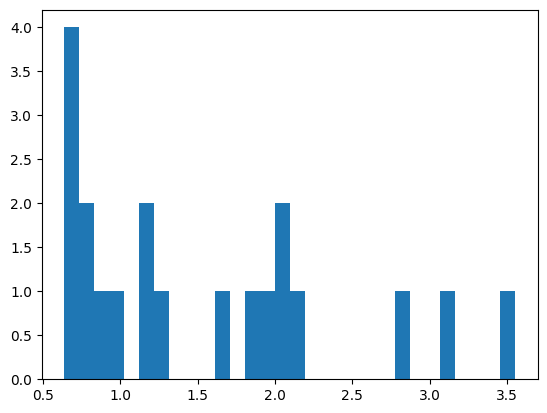

In [ ]:
samples=20
truncexp_samples = truncexpon.rvs(b=10,loc=0.6,scale=1, size=samples)
plt.hist(truncexp_samples,bins=30)

In [ ]:
samples = uniform_samples
res = truncexpon.fit(samples, fb=max(samples), fscale=1, method="mm")
print(res)
b, loc, scale = res[0], res[1], res[2]
#np.sum(np.log(truncexpon(res).pdf(truncexp_samples)))
lln_exp = np.sum(np.log(0.001 + truncexpon(b,loc,scale).pdf(samples)))

res = uniform.fit(samples, method="mle")
loc, scale = res[0], res[1]
print(res)
lln_uni = np.sum(np.log(0.001 + uniform(min(samples),max(samples) - min(samples)).pdf(samples)))

print(lln_exp)
print(lln_uni)

(6.954951665613755, 3.3893584857187333, 1)
(2.0122476136371215, 4.942704051976634)
-671.5455853682432
-318.59640627859244


In [ ]:
x_min_estimator = []
x_debiased_estimator = []
for x in range(500):
    uniform_samples = uniform.rvs(2, 3, size=samples)
    x_min_estimator.append((sorted(uniform_samples)[1]))
    x_debiased_estimator.append(sorted(uniform_samples)[1] - (3 / (samples + 1)))
    


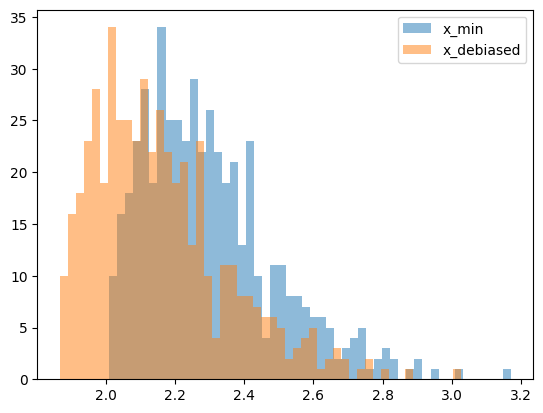

In [ ]:
plt.hist(x_min_estimator, label="x_min",alpha=0.5,bins=50)
plt.hist(x_debiased_estimator, label="x_debiased",alpha=0.5, bins=50)
plt.legend()
plt.show()


In [ ]:

beta_a = 1
beta_k = 100
alpha = 10
samples = 1000
exp_lambda = 1
trunc_norm_mean = 1
trunc_norm_std = 0.5

beta_samples = alpha * beta.rvs(beta_a, beta_k, size=samples)
normal_samples = norm.rvs(0, 0.5, size=samples)
trunc_exp_samples = truncexpon.rvs(alpha, size=samples) * exp_lambda
trunc_norm_samples = (truncnorm.rvs(0, alpha, size=samples) + trunc_norm_mean) / trunc_norm_std

plt.hist(beta_samples + normal_samples,bins=100,label="beta noise",alpha=0.5)
plt.hist(trunc_exp_samples + normal_samples,bins=100,label="trunc exp noise",alpha=0.5)
plt.hist(trunc_norm_samples + normal_samples,bins=100,label="trunc norm noise",alpha=0.5)
plt.hist(normal_samples,bins=100,label="normal only",alpha=0.5)
plt.legend()
plt.show()


In [ ]:
from scipy.stats import norm, expon

# Create a Normal distribution with mean 0 and standard deviation 1
normal_dist = norm(loc=0, scale=1)

# Create an Exponential distribution with scale parameter 2
exponential_dist = expon(scale=2)

# Combine the two distributions by adding them
combined_dist = normal_dist + exponential_dist

TypeError: unsupported operand type(s) for +: 'rv_continuous_frozen' and 'rv_continuous_frozen'

2.0781399999999994